# Цель лабораторной работы
Научиться работать c рекуррентными нейронными сетями в TensorFlow.

# Задание
Требуется собрать рекуррентную нейронную сеть и обеспечить её работу на&nbsp;3 наборах данных:

1. 2&nbsp;связанных временных ряда (двумерный временной ряд).
2. Сигнал, являющийся суперпозицией двух синусоид с&nbsp;разным периодом и смещением.
3. Аналогичный сигнал с&nbsp;наложенным шумом.

# Ход работы

Импорт библиотек.

In [1]:
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import tensorflow as tf
from tqdm import trange

In [3]:
tf.__version__

'1.15.2'

Настроим отображение графиков.

In [0]:
%matplotlib inline
set_matplotlib_formats("retina")

Код для построения графиков

In [0]:
def gr(X, Y, outputs, batch_size):
    output_dim = X.shape[2]
    for j in range(batch_size):
        plt.figure(figsize=(12, 3))
        
        for k in range(output_dim):
            past = X[:,j,k]
            expected = Y[:,j,k]
            pred = outputs[:,j,k]

            label1 = "Seen (past) values" if k==0 else "_nolegend_"
            label2 = "True future values" if k==0 else "_nolegend_"
            label3 = "Predictions" if k==0 else "_nolegend_"

            plt.plot(range(len(past)), past , "o--b", label=label1)
            plt.plot(range(len(past), len(expected)+len(past)),
                     expected, "x--b", label=label2)
            plt.plot(range(len(past), len(pred)+len(past)),
                     pred, "o--y", label=label3)

        plt.legend(loc='best')
        plt.title("Predictions vs true values")
        plt.show()

## Генерация данных
Вставим код для генерации данных, требуемых по заданию.

### Упражнение 1

Двумерный ряд

In [0]:
def generate_x_y_data_v1(isTrain, batch_size):
    seq_length = 10

    batch_x = []
    batch_y = []
    for _ in range(batch_size): 
        # Одна итерация цикла генерирует 1 пакет данных 
        rand = random.random() * 2 * math.pi
        
        # Генерируем набор данных по заданному закону
        # генерирует набор точек, равномерно распредленных
        # по заданному интервалу 
        # (границы интервала смещены на случайную величину)
        sig1 = np.sin(np.linspace(0.0 * math.pi + rand,
                                  3.0 * math.pi + rand, seq_length * 2))
        sig2 = np.cos(np.linspace(0.0 * math.pi + rand,
                                  3.0 * math.pi + rand, seq_length * 2))
        
        # первую половину сигналов берем на обучающую выборку,
        # вторую - на контрольную
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x2 = sig2[:seq_length]
        y2 = sig2[seq_length:]
        
        x_ = np.array([x1, x2])
        y_ = np.array([y1, y2])
        x_, y_ = x_.T, y_.T
    
        batch_x.append(x_)
        batch_y.append(y_)
    
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y) 
    # размерность: (batch_size , seq_length , output_dim)
    # транспонируем, чтобы привести к нужной размерности
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2)) 
    # размерность: (seq_length , batch_size , output_dim)
    
    return batch_x , batch_y

### Упражнение 2

In [0]:
def generate_x_y_data_two_freqs(isTrain, batch_size, seq_length):
    batch_x = [] 
    batch_y = []

    for _ in range(batch_size):
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() + 0.1
        
        sig1 = amp_rand * np.sin(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand,
            seq_length * 2)
        )
        
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() * 1.2
        sig1 = amp_rand * np.cos(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand,
            seq_length * 2)
        ) + sig1
        
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x_ = np.array([x1])
        y_ = np.array([y1])
        x_, y_ = x_.T, y_.T
        
        batch_x.append(x_)
        batch_y.append(y_)
    
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    # размерность: (batch_size , seq_length , output_dim)
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    # размерность: (seq_length , batch_size , output_dim)

    return batch_x , batch_y

In [0]:
def generate_x_y_data_v2(isTrain, batch_size):
    return generate_x_y_data_two_freqs(isTrain, batch_size, seq_length=15)

### Упражнение 3

In [0]:
def generate_x_y_data_v3(isTrain, batch_size):
    seq_length = 30
    x, y = generate_x_y_data_two_freqs(
        isTrain, batch_size, seq_length=seq_length)
    noise_amount = random.random() * 0.15 + 0.10
    x = x + noise_amount * np.random.randn(seq_length, batch_size, 1)

    avg = np.average(x)
    std = np.std(x) + 0.0001
    x = x - avg
    y = y - avg
    x = x / std / 2.5
    y = y / std / 2.5

    return x, y

## Описание модели
Напишем весь код, требуемый для модели. Сначала создадим сессию.

In [0]:
sess = tf.InteractiveSession()

Теперь создадим функцию, выдающую требуемый граф вычислений.

In [0]:
def create_model(input_len, input_dim=1,
                 output_len=None, output_dim=None,
                 hidden_dim=12, layers_stacked_count=2,
                 learning_rate=0.007, lr_decay=0.92,
                 momentum=0.5, lambda_l2_reg=0.003):
    if output_len is None:
        output_len = input_len
    if output_dim is None:
        output_dim = input_dim
    
    print(locals())
    
    g = tf.Graph()
    with g.as_default():
        with tf.variable_scope('Seq2seq'):
            enc_inp = [
                tf.placeholder(tf.float32, shape=(None, input_dim),
                               name="inp_{}".format(t))
                    for t in range(input_len)
            ]

            expected_sparse_output = [
                tf.placeholder(tf.float32 , shape=(None, output_dim),
                               name="expected_sparse_output_".format(t))
                    for t in range(output_len)
            ]

            dec_inp = [tf.zeros_like(enc_inp[0], dtype=np.float32,
                                     name="GO")] + enc_inp[:-1]

            cells = []
            for i in range(layers_stacked_count):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.GRUCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)

            w_in = tf.Variable(tf.random_normal([input_dim, hidden_dim]))
            b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
            w_out = tf.Variable(tf.random_normal([hidden_dim , output_dim]))
            b_out = tf.Variable(tf.random_normal([output_dim]))

            reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in)
                               for i in enc_inp]

            seq2seq = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq
            dec_outputs, dec_memory = seq2seq(enc_inp, dec_inp, cell)

            output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
            reshaped_outputs = [output_scale_factor * (tf.matmul(i, w_out)
                                + b_out) for i in dec_outputs]

        with tf.variable_scope('Loss'):
            # L2 loss
            output_loss = 0
            for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
                output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))

            # слагаемое, отвечающее за L2 регуляризацию
            reg_loss = 0
            for tf_var in tf.trainable_variables():
                if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
                    reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

            loss = output_loss + lambda_l2_reg * reg_loss

        with tf.variable_scope('Optimizer'):
            optimizer = tf.train.RMSPropOptimizer(learning_rate,
                                                  decay=lr_decay,
                                                  momentum=momentum)
            train_op = optimizer.minimize(loss)
    return (g, enc_inp, expected_sparse_output, train_op, loss,
            reshaped_outputs)

Функция, которая будет запускать модель с необходимыми данными

In [0]:
def run_model(model, generator, batch_size=32,
              nb_iters=150, nb_predictions=1):
    if nb_iters % 10 != 0:
        raise ValueError('nb_iters does not divide on 10')
    
    g, x_vars, y_vars, train_op, loss, result = model
    
    def train_batch(batch_size):
        X, Y = generator(isTrain=True, batch_size=batch_size)
        feed_dict = {x_vars[t]: X[t] for t in range(len(x_vars))} 
        feed_dict.update({y_vars[t]: Y[t] for t in range(len(y_vars))})

        _, loss_t = sess.run([train_op, loss], feed_dict)
        return loss_t

    def test_batch(batch_size):
        X, Y = generator(isTrain=False, batch_size=batch_size)
        feed_dict = {x_vars[t]: X[t] for t in range(len(x_vars))} 
        feed_dict.update({y_vars[t]: Y[t] for t in range(len(y_vars))})

        loss_t = sess.run(loss, feed_dict)
        return loss_t

    train_losses = []
    test_losses = []

    with g.as_default():
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            test_loss = -1
            with trange(nb_iters+1, ncols=70) as tq:
                for t in tq:
                    train_loss = train_batch(batch_size)
                    train_losses.append(train_loss)
                    tq.set_postfix(train=train_loss, test=test_loss)

                    if t % 10 == 0:
                        test_loss = test_batch(batch_size)
                        test_losses.append(test_loss)
                        tq.set_postfix(train=train_loss, test=test_loss)

            # Show loss graph
            plt.figure(figsize=(12, 6))
            plt.plot(
                (np.array(range(0, len(test_losses))) / 
                 float(len(test_losses)-1) * (len(train_losses)-1)),
                np.log(test_losses),
                label="Test loss"
            )
            plt.plot(
                np.log(train_losses),
                label="Train loss"
            )
            plt.title("Training errors over time (on a logarithmic scale)")
            plt.xlabel('Iteration')
            plt.ylabel('log(Loss)')
            plt.legend(loc='best')
            plt.show()
            
            # Show sample graphs
            X, Y = generator(isTrain=False, batch_size=nb_predictions)
            feed_dict = {x_vars[t]: X[t] for t in range(len(x_vars))}
            outputs = np.array(sess.run(result, feed_dict))
            gr(X, Y, outputs, nb_predictions)

## Выполнение упражений

### Упражнение 1

{'lambda_l2_reg': 0.003, 'momentum': 0.5, 'lr_decay': 0.92, 'learning_rate': 0.007, 'layers_stacked_count': 2, 'hidden_dim': 12, 'output_len': 10, 'input_len': 10, 'output_dim': 2, 'input_dim': 2}
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method in

100%|███████| 201/201 [00:07<00:00, 27.84it/s, test=1.31, train=0.909]


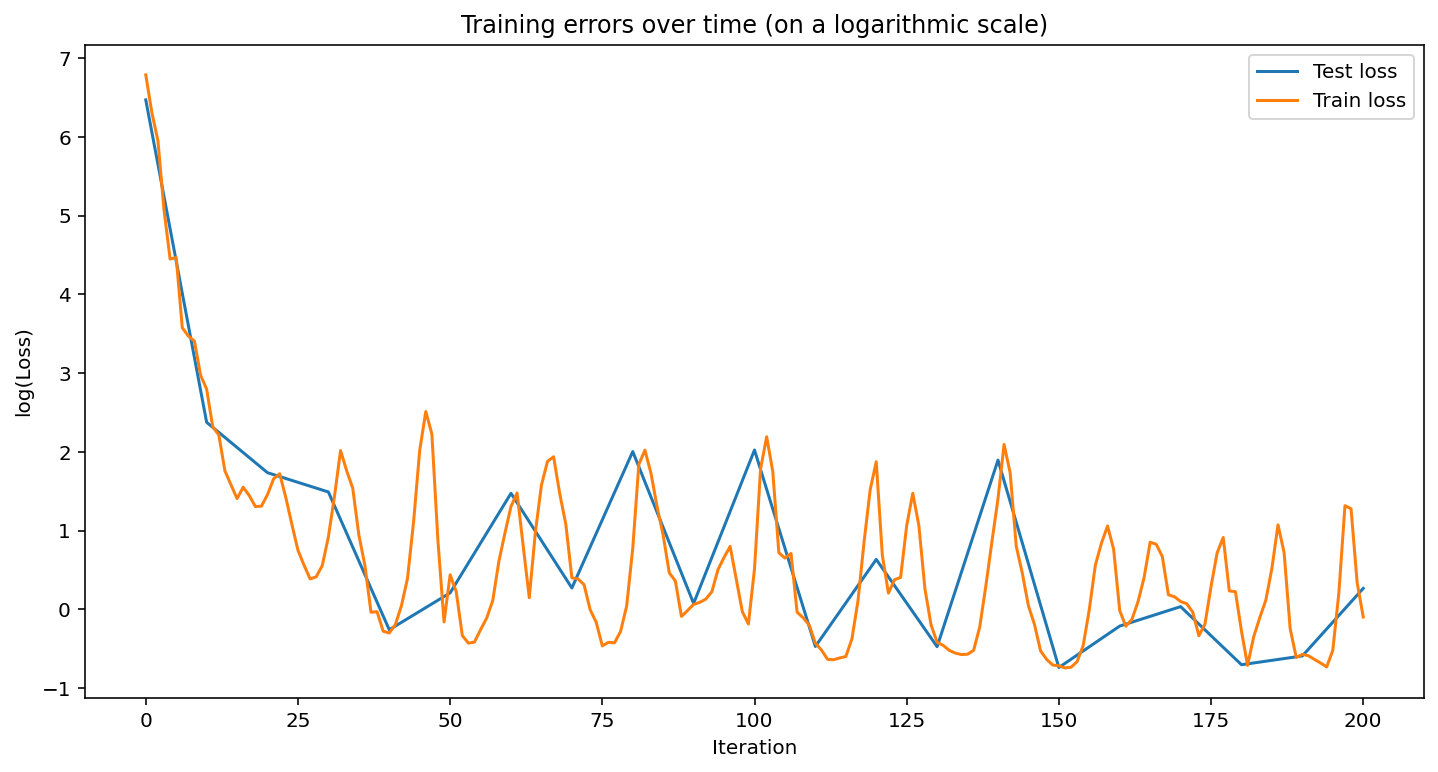

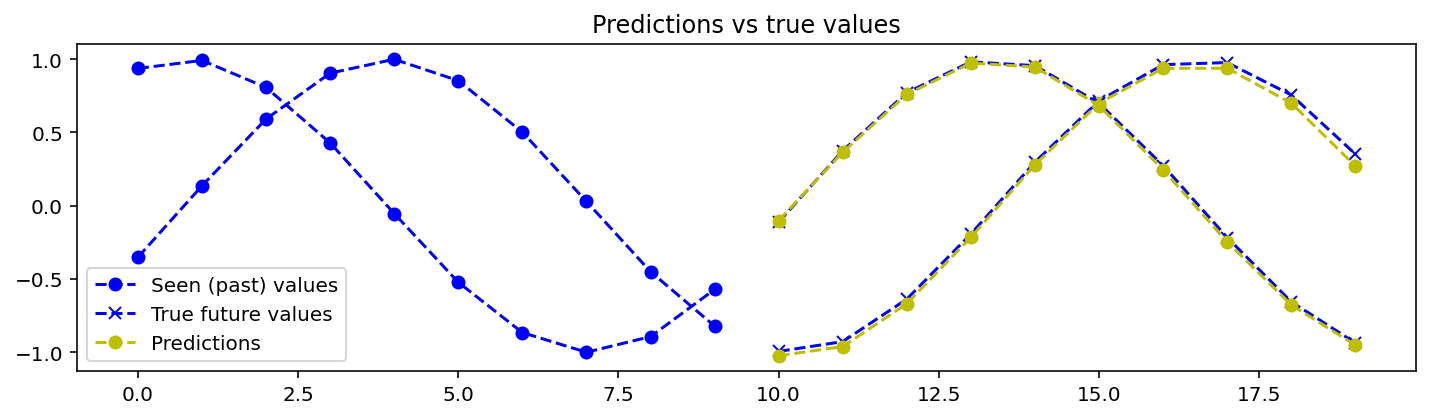

In [14]:
generator = generate_x_y_data_v1
x, _ = generator(True, 1)
model = create_model(x.shape[0], x.shape[2])
run_model(model, generator, nb_iters=200)

### Упражнение 2

{'lambda_l2_reg': 0.003, 'momentum': 0.5, 'lr_decay': 0.92, 'learning_rate': 0.007, 'layers_stacked_count': 2, 'hidden_dim': 50, 'output_len': 15, 'input_len': 15, 'output_dim': 1, 'input_dim': 1}


100%|██████| 2501/2501 [01:19<00:00, 31.64it/s, test=57.2, train=47.8]


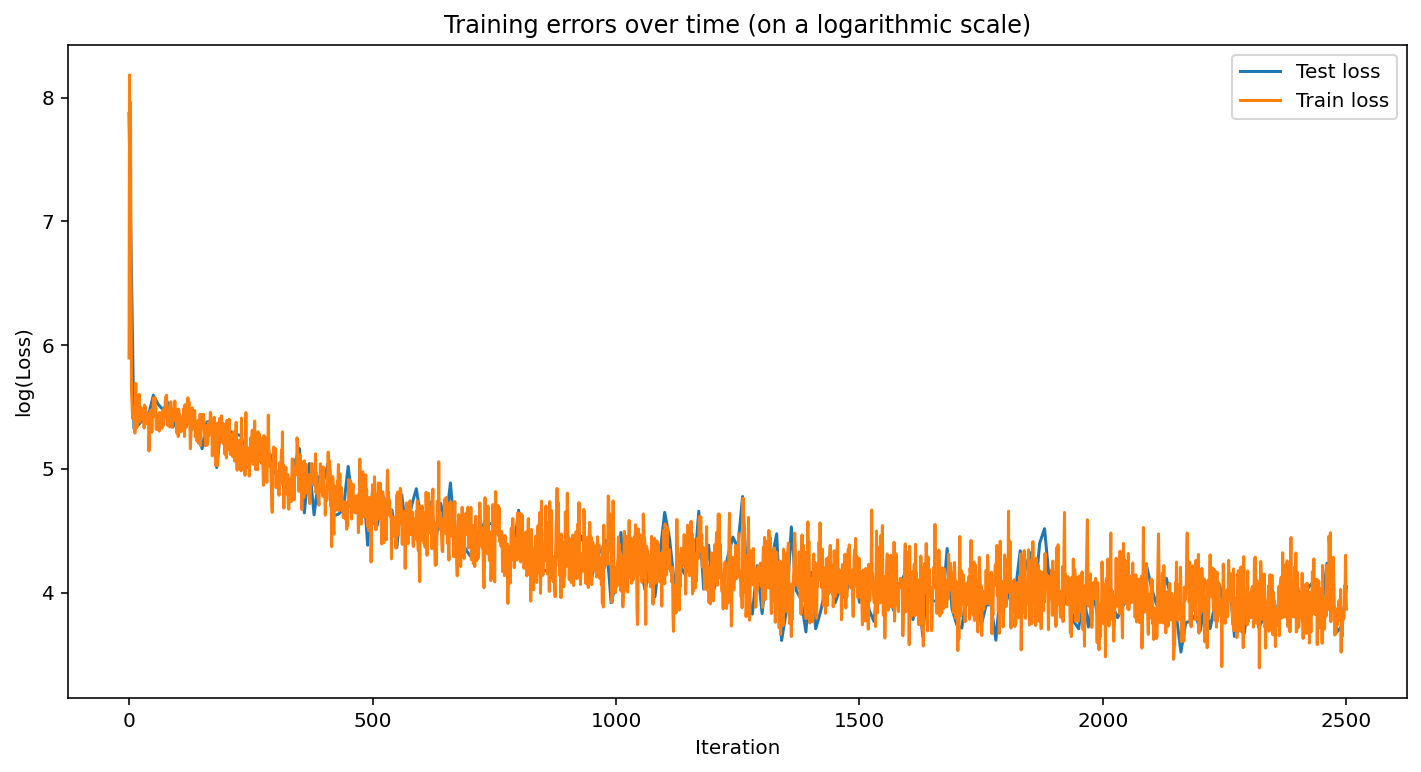

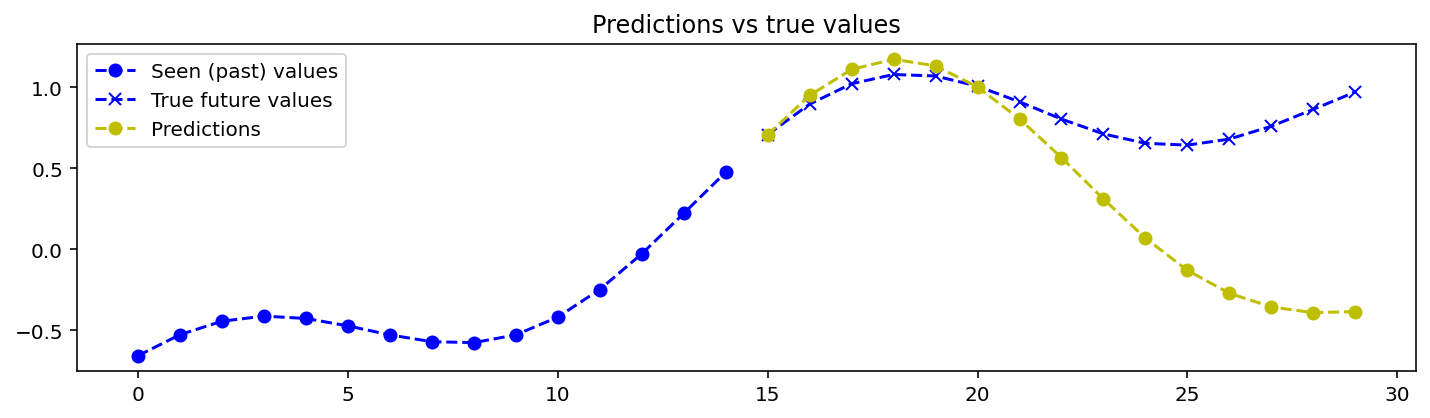

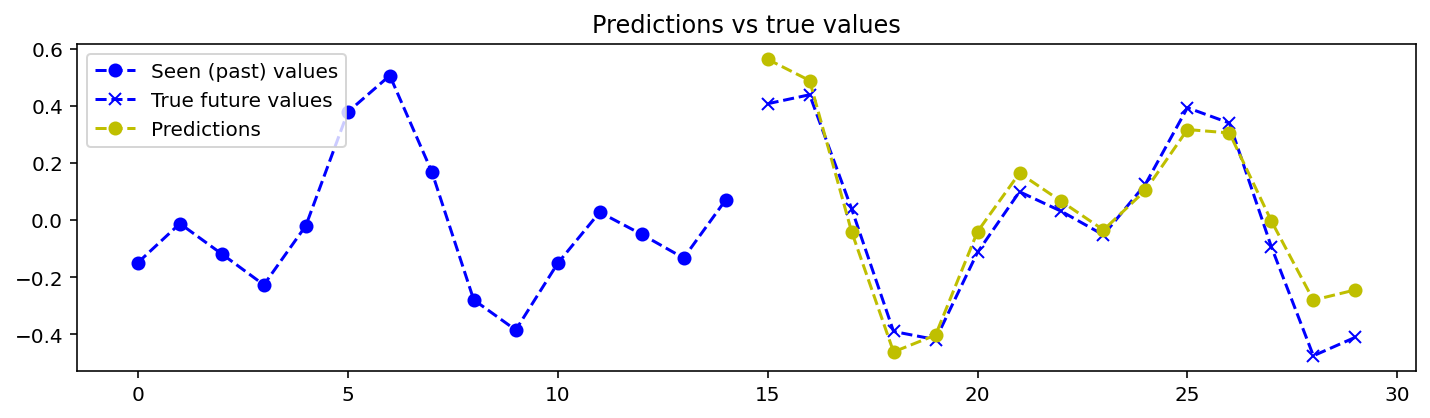

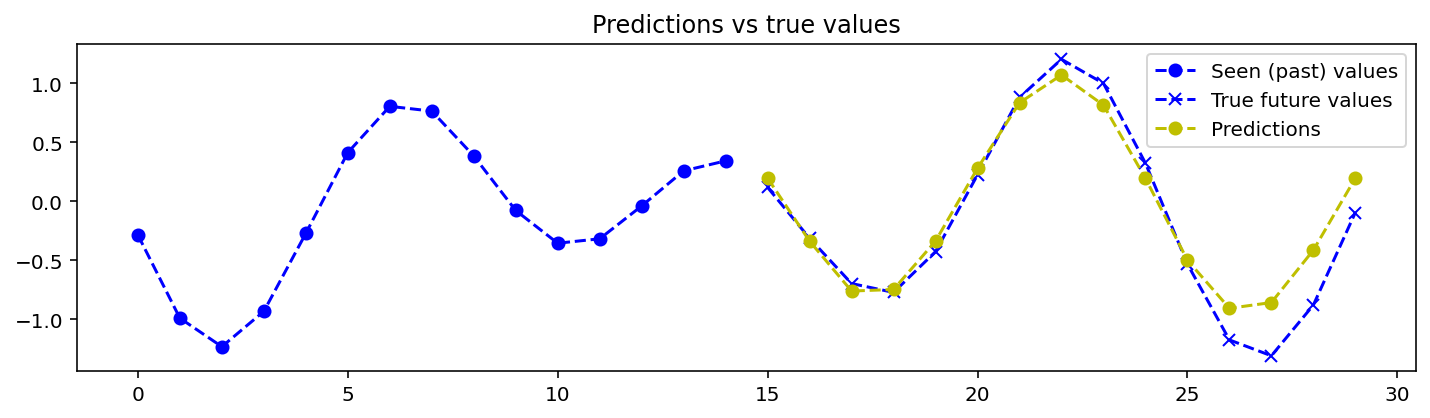

In [15]:
generator = generate_x_y_data_v2
x, _ = generator(True, 1)
model = create_model(x.shape[0], x.shape[2],
                     hidden_dim=50)
run_model(model, generator, batch_size=64,
          nb_iters=2500, nb_predictions=3)

### Упражнение 3

{'lambda_l2_reg': 0.003, 'momentum': 0.5, 'lr_decay': 0.92, 'learning_rate': 0.007, 'layers_stacked_count': 2, 'hidden_dim': 50, 'output_len': 30, 'input_len': 30, 'output_dim': 1, 'input_dim': 1}


100%|██████| 2501/2501 [02:08<00:00, 19.43it/s, test=83.2, train=69.1]


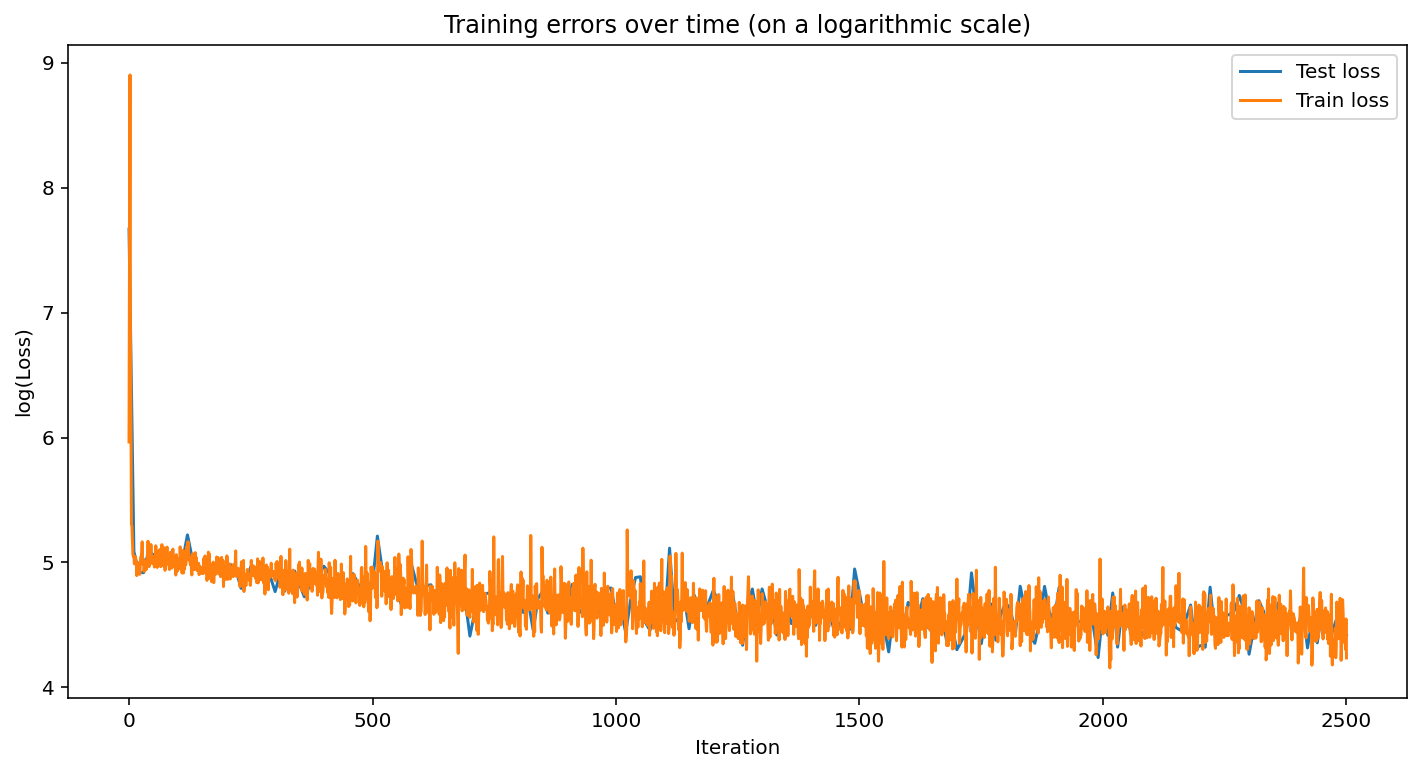

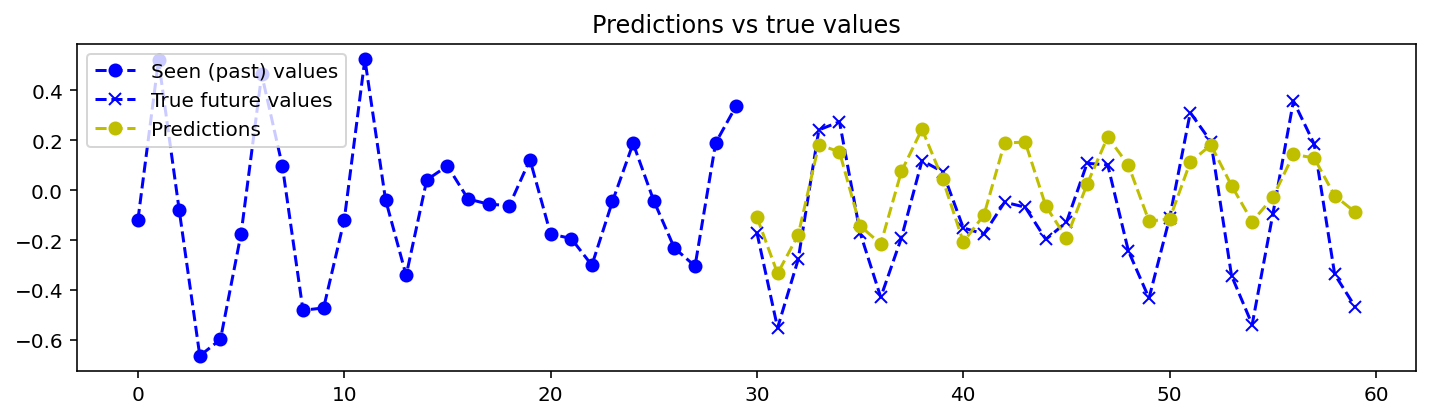

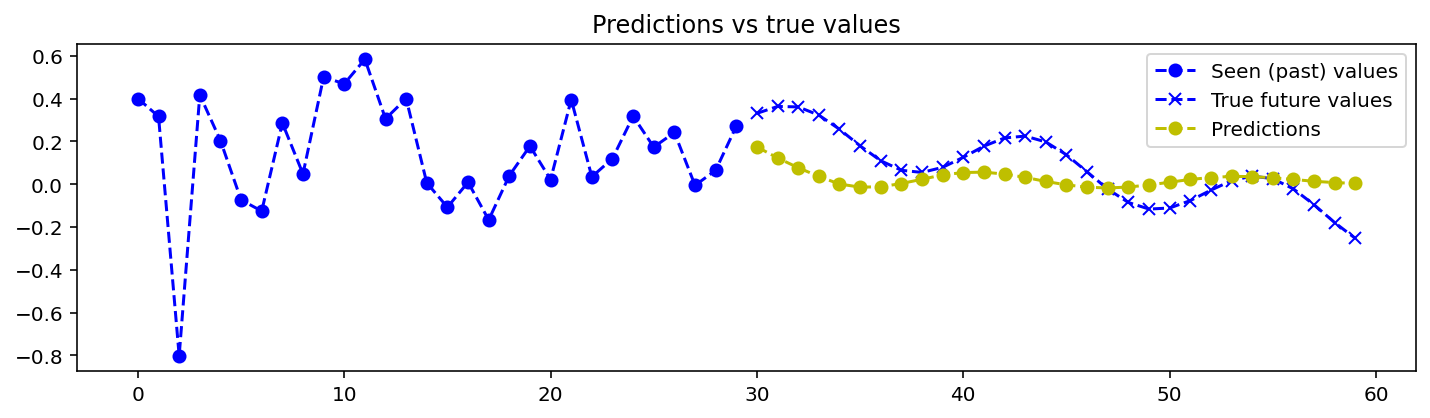

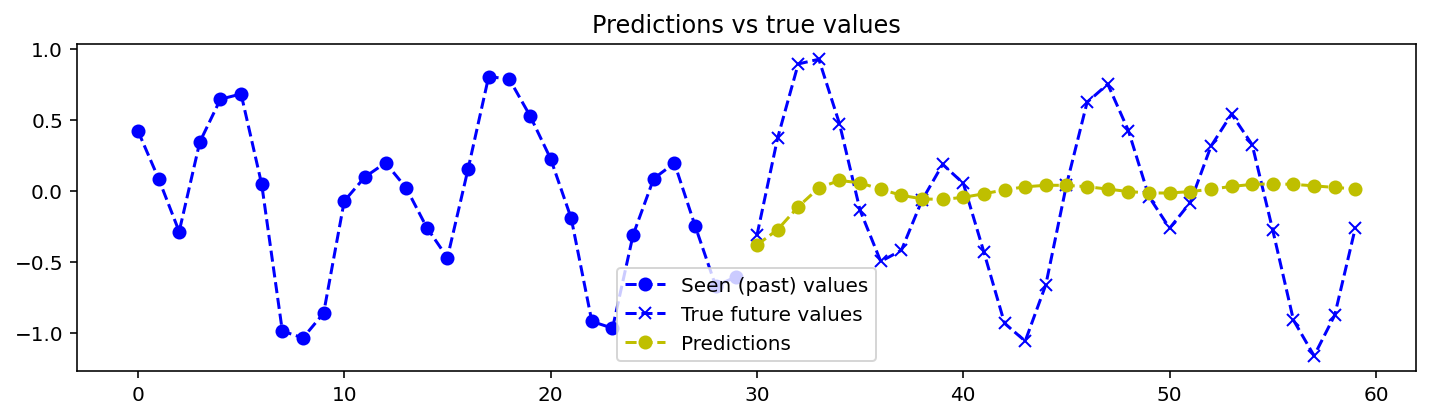

In [16]:
generator = generate_x_y_data_v3
x, _ = generator(True, 1)
model = create_model(x.shape[0], x.shape[2],
                     hidden_dim=50)
run_model(model, generator, batch_size=64,
          nb_iters=2500, nb_predictions=3)

# Ответы на вопросы.

1) Преимущество рекуррентных нейронных сетей перед обычными персептронами.  
В RNN есть память, поэтому она может влиять на следующие входные данные.  
2) Регуляризация и зачем она?  
Штрафует за слишком большие веса (страховка от переобучения). 
 L2(чаще всего),   
 L1 (убирает признаки).   
3) Пакетный, мини-пакетный, онлайновый градиентный спуск.  
Есть градиентный. Там нужно считать по всей матрице, это очень долго и сложно. Поэтому используют стохастический (онлайновый). В нем берется случайный пример и по нему считается градиент. В пакетном считается по всей выборке, но веса обновляются только когда полностью пройдет эпоха. В случае мини-пакетного примеры разбиваются на несколько наборов и затем они используются для обновления весов и подсчета ошибки.
4) Ответ на вопрос по коду. :-)

# Список литературы
[1] Google. Tensorflow. 2018. Feb. url - https://www.tensorflow.org/install/install_windows.    
[2] url - https://virtualenv.pypa.io/en/stable/userguide/.    
[3] Microsoft. about_Execution_Policies. 2018. url - https://technet.microsoft.com/en- us/library/dd347641.aspx.   
[4] Jupyter Project. Installing Jupyter. 2018. url - http://jupyter.org/install.  